In [1]:
import sys
sys.path.append('/home/nadzya/Apps/log-anomaly-detector/')

import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
import pandas as pd
import numpy as np 
import datetime
import json

from anomaly_detector.config import Configuration
from anomaly_detector.storage.mongodb_storage import MongoDBStorage
from anomaly_detector.storage.storage_attribute import MGStorageAttribute

from bson.json_util import dumps

from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import re

In [3]:
def config():
    """Initialize configurations before testing."""
    cfg = Configuration()
    cfg.MG_HOST = "172.17.18.83"
    cfg.MG_PORT = 27017
    cfg.MG_CERT_DIR = ""
    cfg.MG_INPUT_DB = "anomalydb"
    cfg.MG_INPUT_COL = "utm_anomaly"
    cfg.HOSTNAME_INDEX = "hostname"
    cfg.DATETIME_INDEX = "timestamp"
    cfg.MG_CA_CERT = "/home/nadzya/Apps/log-anomaly-detector/config_files/LAD_CA.crt"
    cfg.MG_USER = 'dbadmin'
    cfg.MG_PASSWORD = 'password123'
    cfg.AGGR_VECTOR_LENGTH = 25
    cfg.AGGR_WINDOW = 5
    cfg.AGGR_EPS = 0.1
    cfg.AGGR_MIN_SAMPLES = 2
    return cfg

In [4]:
class DataCleaner:
    """Data cleaning utility functions."""

    @classmethod
    def _clean_message(cls, line):
        """Remove all none alphabetical characters from message strings."""
        words = list(re.findall("[a-zA-Z]+", line))
        return words
        
    @classmethod
    def _preprocess(cls, data):
        """Provide preprocessing for the data before running it through W2V and SOM."""
        def to_str(x):
            """Convert all non-str lists to string lists for Word2Vec."""
            ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
            return ret

        for col in data.columns:
            if col == "message":
                data[col] = data[col].apply(cls._clean_message)
            else:
                data[col] = data[col].apply(to_str)

        data = data.fillna("EMPTY")

    @classmethod
    def format_log(cls, config, es_dataset):
        """Format log will extract prefix out of the message."""
        if config.LOG_FORMATTER == "strip_prefix":
            for es_data in es_dataset:
                try:
                    if len(es_data['message'].split("] ")) > 1:
                        es_data["orig_message"] = es_data["message"]
                        es_data["message"] = es_data["message"].split("] ")[1]
                except Exception as ex:
                    logging.debug("Error {} in log formatter: {}".format(ex, config.ES_LOG_FORMATTER))

In [5]:
class MongoDBDataStorageSource(DataCleaner, MongoDBStorage):
    """MongoDB data source implementation."""

    NAME = "mg.source"

    def __init__(self, config):
        """Initialize mongodb storage backend."""
        self.config = config
        MongoDBStorage.__init__(self, config)

    def retrieve(self, storage_attribute: MGStorageAttribute):
        """Retrieve data from MongoDB."""

        mg_input_db = self.mg[self.config.MG_INPUT_DB]
        now = datetime.datetime.now()

        mg_data = mg_input_db[self.config.MG_INPUT_COL]

        if self.config.LOGSOURCE_HOSTNAME != 'localhost':
            query = {
                self.config.DATETIME_INDEX:  {
                    '$gte': now - datetime.timedelta(seconds=storage_attribute.time_range),
                    '$lt': now
                },
                self.config.HOSTNAME_INDEX: self.config.LOGSOURCE_HOSTNAME
            }
        else:
            query = {
                self.config.DATETIME_INDEX:  {
                    '$gte': now - datetime.timedelta(seconds=storage_attribute.time_range),
                    '$lt': now
                }
            }
        mg_data = mg_data.find(query).sort(self.config.DATETIME_INDEX, -1).limit(storage_attribute.number_of_entries)
        self.mg.close()

        if not mg_data.count():   # if it equials 0:
            return pandas.Dataframe(), mg_data

        mg_data = dumps(mg_data, sort_keys=False)

        mg_data_normalized = pd.DataFrame(pd.json_normalize(json.loads(mg_data)))
    
        self._preprocess(mg_data_normalized)

        return mg_data_normalized, json.loads(mg_data)

In [6]:
def get_lad_word2vec(config, df):
    w2v = W2VModel(config)
    w2v.create(df, config.AGGR_VECTOR_LENGTH, config.AGGR_WINDOW)
    return (w2v.one_vector(df), w2v.model["message"].wv)

In [7]:
def get_gensin_w2v(config, df):
    w2v = Word2Vec(sentences=list(df["message"]), size=config.AGGR_VECTOR_LENGTH, window=config.AGGR_WINDOW)
    
    vectors = []
    for x in list(df["message"]):
        temp = []
        for word in x:
            if word in w2v.wv:
                #print(len(w2v.wv[word]))
                temp.append(w2v.wv[word])
            else:
                temp.append(np.array([0]*config.AGGR_VECTOR_LENGTH))
        vectors.append(temp)
    return vectors

In [8]:
def log_words_to_vector(log_list):
    result = []
    log_array_transposed = np.array(log_list, dtype=object).transpose()
    for coord in log_array_transposed:
        result.append(np.mean(coord)) 
    return result

In [9]:
def all_logs_to_vectors(logs):
    result = []
    for log in logs:
        result.append(log_words_to_vector(log))
    return np.array(result)

In [10]:
def add_cluster_label_to_df_dbscan(config, df, vectors):
    dbscan = DBSCAN(eps=config.AGGR_EPS, min_samples=cfg.AGGR_MIN_SAMPLES)
    clusters = dbscan.fit_predict(vectors)
    df["cluster_db"] = clusters
    return clusters

In [11]:
def add_cluster_label_to_df_ap(config, df, vectors):
    ap = AffinityPropagation(random_state=0, max_iter=2)
    clusters = ap.fit_predict(vectors)
    df["cluster_ap"] = clusters
    return clusters

In [12]:
def aggregate_logs(df, df_json, clusters):
    aggregated = []
    for cluster in np.unique(clusters):
        messages = []
        for i in list(df.loc[df['cluster_db'] == cluster].index):
            messages.append(df_json[i]["message"])

        if cluster == -1:
            for msg in messages:
                aggregated.append((msg, 1, []))
                #aggregated.append(msg)
        else:
            splited_messages = [x.split() for x in messages]
            splited_transpose = [list(row) for row in zip(*splited_messages)]
            result_string = ""
            var_num = 0

            for x in splited_transpose:
                if len(set(x)) == 1:
                    result_string += x[0] + " "
                else:
                    result_string += "***" + " "

            msg_num = len(messages)
            aggregated.append((result_string[:-1], msg_num, messages))
            #aggregated.append(result_string[:-1])

    return aggregated

In [13]:
cfg = config()
mg = MongoDBDataStorageSource(cfg)
df, json_logs = mg.retrieve(MGStorageAttribute(30*86400, 500))

Loading Configuration
Connection to MongoDB at 172.17.18.83 with SSL/TLS using CA certificate in /home/nadzya/Apps/log-anomaly-detector/config_files/LAD_CA.crt (verify=False).
<ipython-input-5-5062e907c919>:37: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if not mg_data.count():   # if it equials 0:
Peer did not staple an OCSP response
No authority access information, soft fail
Peer did not staple an OCSP response
No authority access information, soft fail
Peer did not staple an OCSP response
No authority access information, soft fail


In [14]:
df = pd.DataFrame(df["message"])
vectors = get_gensin_w2v(cfg, df)

consider setting layer size to a multiple of 4 for greater performance
collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 151 word types from a corpus of 16222 raw words and 500 sentences
Loading a fresh vocabulary
effective_min_count=5 retains 121 unique words (80% of original 151, drops 30)
effective_min_count=5 leaves 16176 word corpus (99% of original 16222, drops 46)
deleting the raw counts dictionary of 151 items
sample=0.001 downsamples 66 most-common words
downsampling leaves estimated 6235 word corpus (38.5% of prior 16176)
estimated required memory for 121 words and 25 dimensions: 84700 bytes
resetting layer weights
training model with 3 workers on 121 vocabulary and 25 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
job loop exiting, total 2 jobs
worker exiting, processed 0 jobs
worker thread finished; awaiting finish of 2 more threads
worker exiting, processed 1 jobs
worker thread finished; awaiting f

In [15]:
mean_vectors = all_logs_to_vectors(vectors)

# DBSCAN

In [16]:
clusters = add_cluster_label_to_df_dbscan(cfg, df, mean_vectors)
clusters

array([ 0,  1,  0,  1,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,  1,  1,  0,
        1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0,  2,
        3,  2,  0,  2,  3,  2,  0,  0,  0,  3,  4,  2,  3,  2,  3,  0,  3,
        4,  2,  3,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  2,  0,  2,  2,  0,  2,  0,  1,  0,  5,  5,  5,
        5,  5,  5,  5,  0,  0,  0,  0,  0,  0,  0,  5,  5,  5,  5,  0,  5,
        5,  5,  0,  0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,
        2,  2,  0,  0,  5,  5,  5,  5,  0,  5,  5,  0,  2,  0,  2,  2,  2,
        0,  2,  2,  0,  2,  2,  0,  2,  5,  6,  6,  6,  5,  6,  6,  6,  5,
        6,  6,  6,  5,  6,  6,  6,  5,  6,  6,  6,  5,  6,  6,  6,  0,  0,
        0,  0,  5,  6,  6,  6,  0,  5,  6,  6,  6,  5,  6,  6,  6,  5,  6,
        6,  6,  0,  5,  6,  6,  6,  5,  6,  6,  6,  5,  6,  6,  6,  0,  0,
        5,  5,  5,  5,  5

Loaded backend module://matplotlib_inline.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


/home/nadzya/.local/lib/python3.8/site-packages/matplotlib/collections.py:1134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


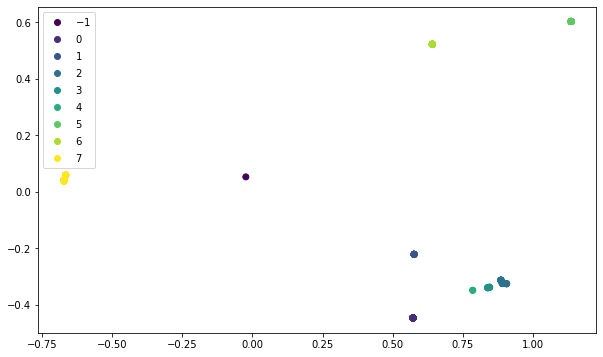

In [21]:
%pylab inline

pca = PCA(n_components=2, random_state=0)
data_2d_pca = pca.fit_transform(mean_vectors)

pylab.figure(figsize=(10, 6))
scat = pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c=list(df["cluster_db"]))
pylab.legend(*scat.legend_elements(num=np.unique(clusters)))

In [30]:
[json_logs[i]["message"] for i in df.loc[df["cluster_db"] == 3]["message"].index]

['<13>Dec  7 12:15:27 U22020000000877 vectra_standard -: HOST [host@41261 category="HOST SCORING" hostName="paul-lptp" currentIP="172.17.17.151" dvchost="172.17.18.39" threat="66" certainty="56" privilege="1" scoreDecreases="False" URL="https://172.17.18.39/hosts/4113" UTCTime="1638868527.30991" sourceKeyAsset="False" destKeyAsset="True" hostRoles=""]',
 '<13>Dec  7 12:15:27 U22020000000877 vectra_standard -: HOST [host@41261 category="HOST SCORING" hostName="paul-lptp" currentIP="172.17.17.151" dvchost="172.17.18.39" threat="66" certainty="56" privilege="1" scoreDecreases="False" URL="https://172.17.18.39/hosts/4113" UTCTime="1638868527.30991" sourceKeyAsset="False" destKeyAsset="True" hostRoles=""]',
 '<13>Dec  7 15:15:27 U22020000000877 vectra_standard -: HOST [host@41261 category="HOST SCORING" hostName="ella-850g1" currentIP="172.17.17.103" dvchost="172.17.18.39" threat="48" certainty="9" privilege="1" scoreDecreases="False" URL="https://172.17.18.39/hosts/12529" UTCTime="16388793

In [28]:
np.unique([np.array(mean_vectors[i]) for i in list(df.loc[df["cluster_db"] == 7].index)], axis=0)

array([[-0.05807451, -0.16268024, -0.21573155,  0.76964437,  0.23371701,
         0.20139878, -0.18672833,  0.25037271, -0.18765422,  0.01893318,
         0.55529635, -0.03048346, -0.34950822, -0.39868921,  0.29756826,
         0.42770241,  0.10455499, -0.05116133, -0.23790619, -0.15472175,
        -0.30890929, -0.77871971,  0.71664315, -0.0580928 , -0.19567982],
       [-0.04780196, -0.15088907, -0.21000879,  0.77747514,  0.22921518,
         0.20662746, -0.17402966,  0.25796048, -0.19513738,  0.01552611,
         0.5576897 , -0.02983851, -0.34684701, -0.39993331,  0.29476489,
         0.41884744,  0.0983549 , -0.04179557, -0.23777751, -0.16117207,
        -0.31271037, -0.78840107,  0.72820294, -0.04694566, -0.21136934]])

In [31]:
aggregate_logs(df, json_logs, clusters)

[('<189>date=2021-12-05 time=11:57:00 devname="SLX-FG-VM-166" devid="FGVM010000010982" logid="0100040704" type="event" subtype="system" level="notice" vd="root" eventtime=1638694621914706118 tz="+0300" logdesc="System performance statistics" action="perf-stats" cpu=2 mem=80 totalsession=106 disk=1 bandwidth="70/362" setuprate=3 disklograte=0 fazlograte=0 freediskstorage=28507 sysuptime=20698557 msg="Performance statistics: average CPU: 2, memory:  80, concurrent sessions:  106, setup-rate: 3"',
  1,
  []),
 ('<46>Dec *** *** U22020000000877 -- MARK --',
  100,
  ['<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>Dec  7 07:15:26 U22020000000877 -- MARK --',
   '<46>D

# Affinity Propogation

In [32]:
ap = AffinityPropagation(random_state=0)
clusters_ap = ap.fit_predict(mean_vectors)
clusters_ap

/home/nadzya/.local/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1